In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from windrose import WindroseAxes
%matplotlib inline
sns.set_style("whitegrid")

## Togo Dapaong Solar Dataset EDA

This notebook performs Exploratory Data Analysis (EDA) on the Benin-malanville solar dataset, including profiling, cleaning, and visualization to prepare for region-ranking tasks.

### 1. Setup and Data Loading

### 1.1 Import Libraries


### 1.2 Load Data

* Load the Benin dataset (from data/benin_melanville.csv).

* Convert Timestamp to datetime.

In [4]:
df = pd.read_csv("../data/eda-togo-dapaong_qc.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)
df.head()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
Timestamp,,,,,,,,,,,,,,,,,,
2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


## 2. Summary Statistics & Missing-Value Report

### 2.1 Summary Statistics

In [5]:
numeric_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "Tamb", "RH", "WS", "WSgust", "WD", "BP", "TModA", "TModB"]
summary_stats = df[numeric_cols].describe()
print(summary_stats)

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%         0.000000      24.2000

## 2.2 Missing Values

* Calculate missing values and identify columns with >5% nulls.

          Missing Count  Missing %
Comments         525600      100.0


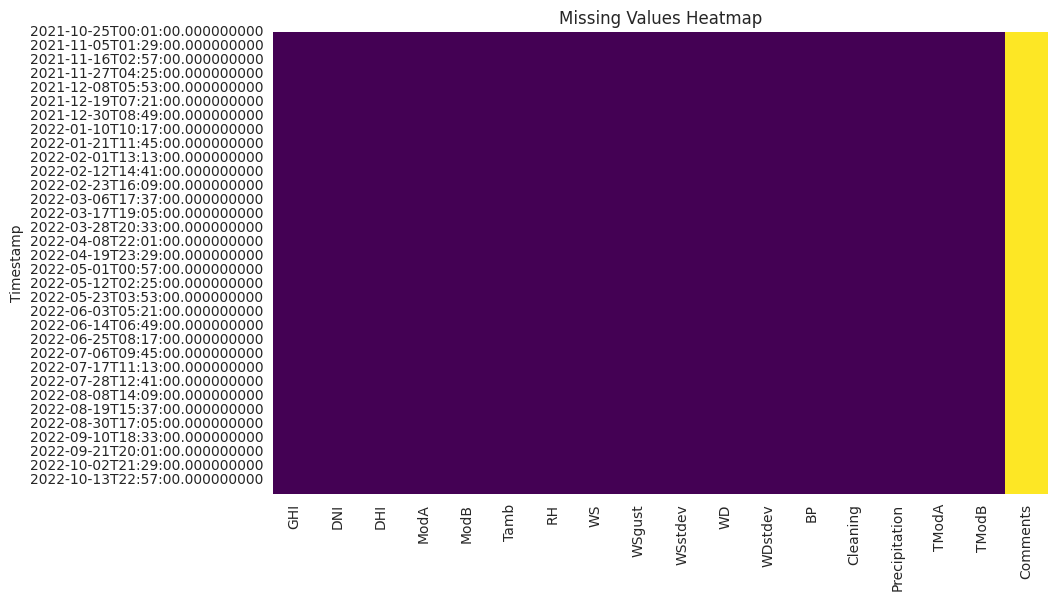

In [6]:
missing_values = df.isna().sum()
missing_percent = (df.isna().sum() / len(df)) * 100
missing_report = pd.DataFrame({"Missing Count": missing_values, "Missing %": missing_percent})
print(missing_report[missing_report["Missing %"] > 5])

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

## 3. Outlier Detection & Basic Cleaning
### 3.1 Outlier Detection
* Compute Z-scores for key columns and flag outliers (|Z| > 3).

Outlier counts:
 GHI        305
DNI       1062
DHI       3415
ModA       137
ModB       206
WS        3510
WSgust    3915
dtype: int64


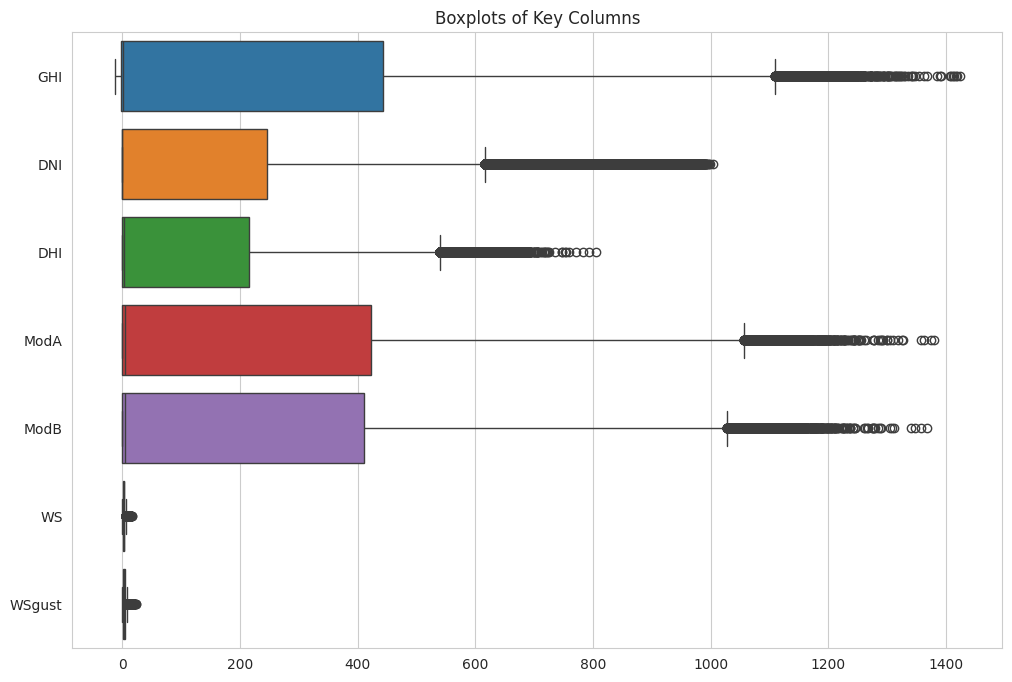

In [7]:
key_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
z_scores = df[key_cols].apply(stats.zscore)
outliers = (z_scores.abs() > 3)
print("Outlier counts:\n", outliers.sum())

# Visualize outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[key_cols], orient="h")
plt.title("Boxplots of Key Columns")
plt.show()

### 3.2 Cleaning

* Handle missing values: impute with median for key columns, drop rows if missing >50%.
* Remove negative values for GHI, DNI, DHI .

In [8]:
# Drop Comments column (100% missing)
df = df.drop(columns=["Comments"])

# Impute missing values with median for key columns
key_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
for col in key_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows with >50% missing values
df = df.dropna(thresh=len(df.columns) * 0.5)

# Remove negative values for irradiance columns
for col in ["GHI", "DNI", "DHI"]:
    df = df[df[col] >= 0]

# Verify cleaning
print("Missing values after cleaning:\n", df.isna().sum())

Missing values after cleaning:
 GHI              0
DNI              0
DHI              0
ModA             0
ModB             0
Tamb             0
RH               0
WS               0
WSgust           0
WSstdev          0
WD               0
WDstdev          0
BP               0
Cleaning         0
Precipitation    0
TModA            0
TModB            0
dtype: int64


### 4. Export Cleaned Data
* Save cleaned DataFrame to data/sierraleon_clean.csv.

In [9]:
df.to_csv("../data/togo_cleaned.csv", index=True)
print("Cleaned data saved to data/sierraleon_clean.csv")

Cleaned data saved to data/sierraleon_clean.csv


### 5. Time Series Analysis

* Plot GHI, DNI, DHI, Tamb vs. Timestamp to observe daily/monthly patterns.

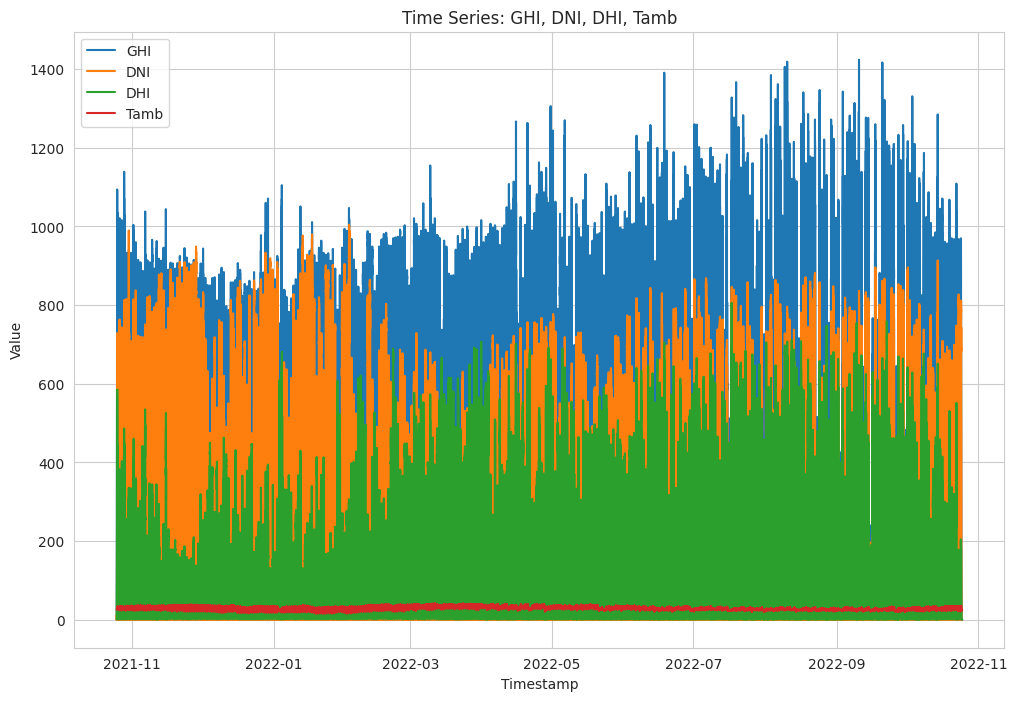

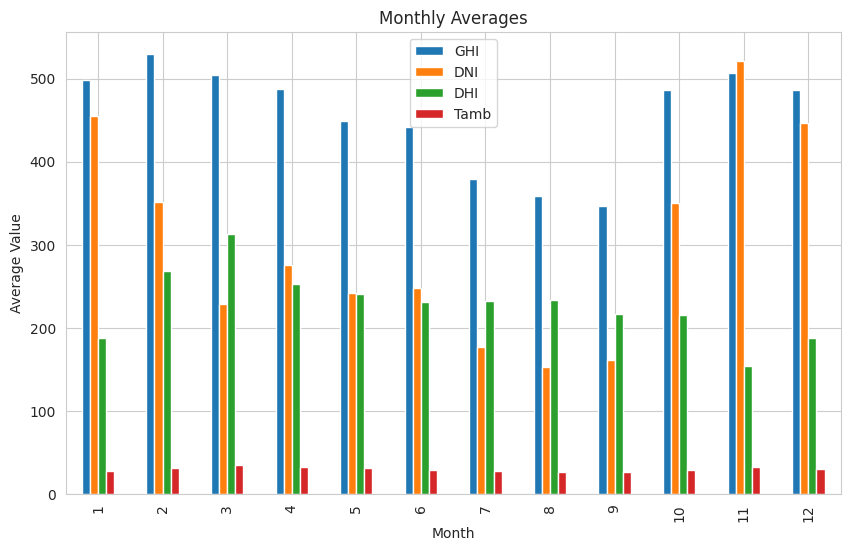

In [10]:
plt.figure(figsize=(12, 8))
for col in ["GHI", "DNI", "DHI", "Tamb"]:
    plt.plot(df.index, df[col], label=col)
plt.title("Time Series: GHI, DNI, DHI, Tamb")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.show()

# Monthly averages
df["Month"] = df.index.month
monthly_avg = df.groupby("Month")[["GHI", "DNI", "DHI", "Tamb"]].mean()
monthly_avg.plot(kind="bar", figsize=(10, 6))
plt.title("Monthly Averages")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.show()

### 6. Cleaning Impact
* Compare ModA and ModB before/after cleaning using the Cleaning flag.

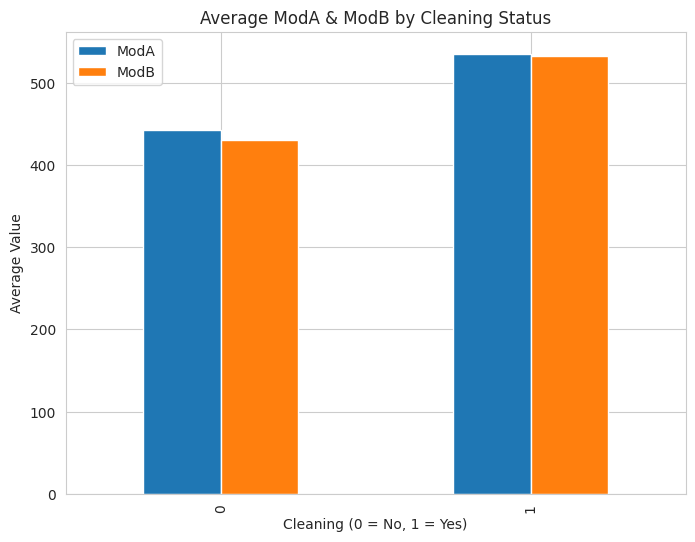

In [11]:
cleaning_impact = df.groupby("Cleaning")[["ModA", "ModB"]].mean()
cleaning_impact.plot(kind="bar", figsize=(8, 6))
plt.title("Average ModA & ModB by Cleaning Status")
plt.xlabel("Cleaning (0 = No, 1 = Yes)")
plt.ylabel("Average Value")
plt.show()

### 7. Correlation & Relationship Analysis

#### 7.1 Correlation Heatmap

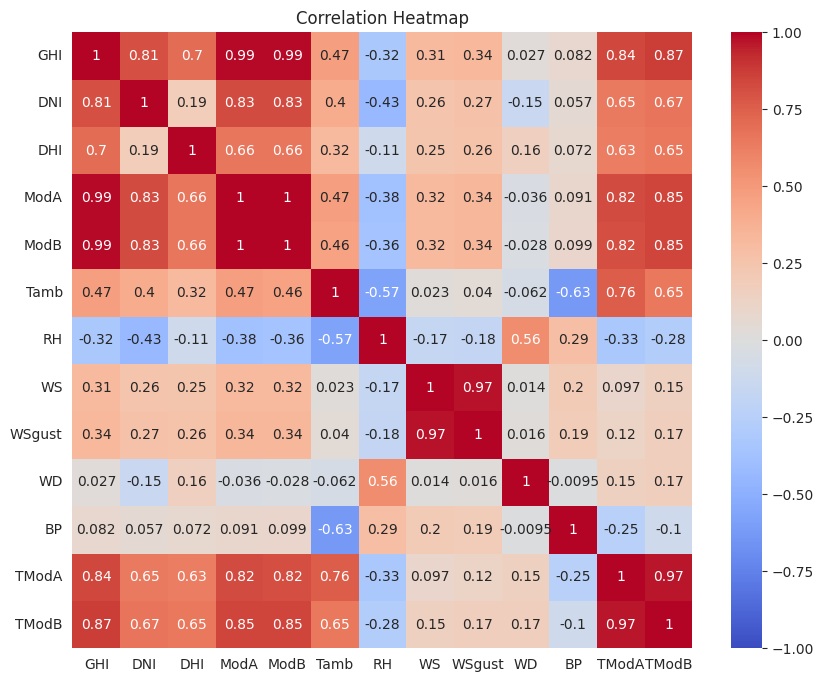

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

#### 7.2 Scatter Plots
* Plot WS, WSgust, WD vs. GHI, and RH vs. Tamb or GHI.

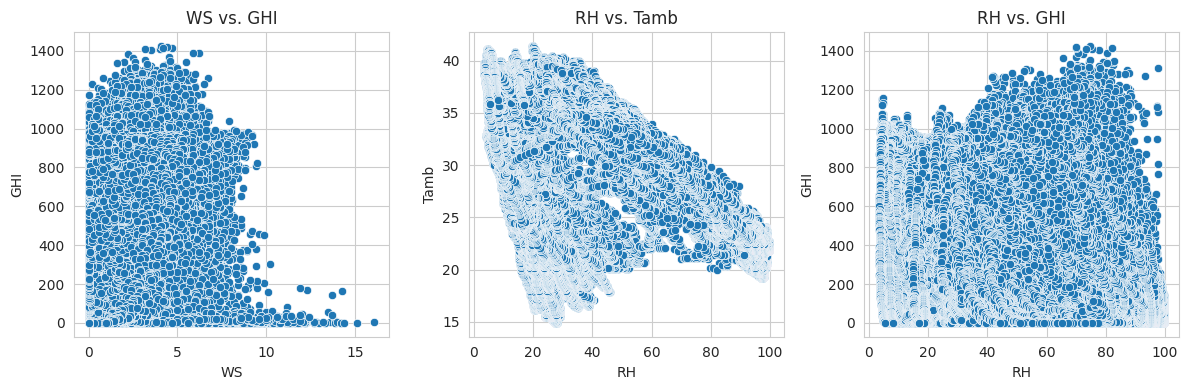

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.scatterplot(x="WS", y="GHI", data=df)
plt.title("WS vs. GHI")
plt.subplot(1, 3, 2)
sns.scatterplot(x="RH", y="Tamb", data=df)
plt.title("RH vs. Tamb")
plt.subplot(1, 3, 3)
sns.scatterplot(x="RH", y="GHI", data=df)
plt.title("RH vs. GHI")
plt.tight_layout()
plt.show()

#### 8. Wind & Distribution Analysis
#### 8.1 Wind Rose
* Plot wind speed (WS) and direction (WD).

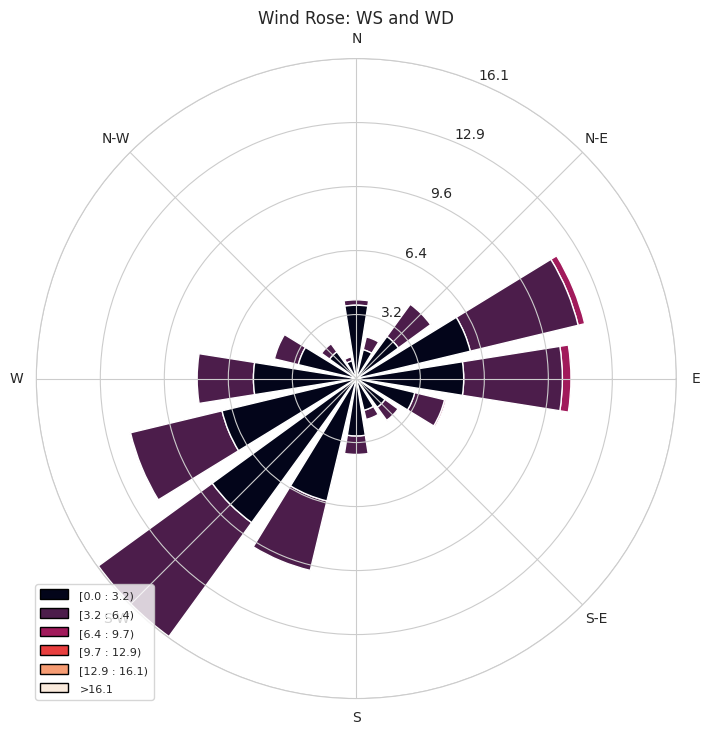

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df["WD"], df["WS"], normed=True, opening=0.8, edgecolor="white")
ax.set_legend()
plt.title("Wind Rose: WS and WD")
plt.show()

#### 8.2 Histograms
* Plot distributions for GHI and WS.

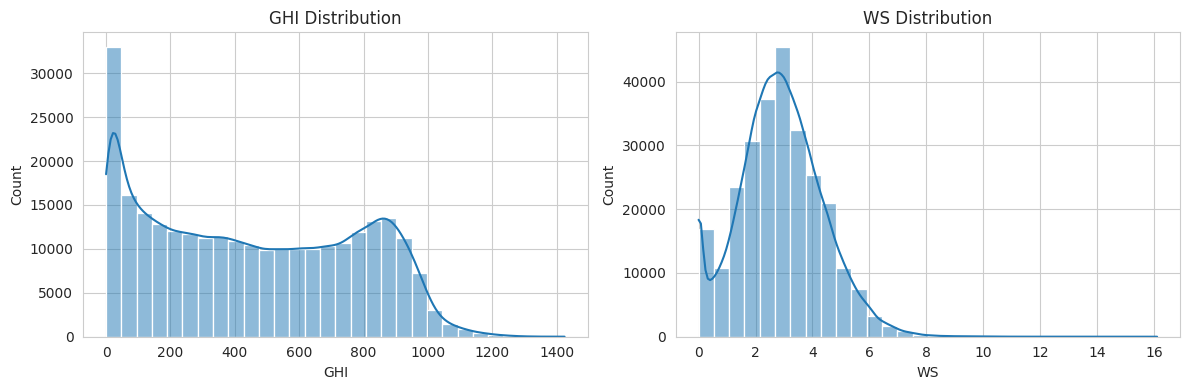

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df["GHI"], bins=30, kde=True)
plt.title("GHI Distribution")
plt.subplot(1, 2, 2)
sns.histplot(df["WS"], bins=30, kde=True)
plt.title("WS Distribution")
plt.tight_layout()
plt.show()

#### 9. Temperature Analysis
* Analyze how RH influences Tamb and GHI.

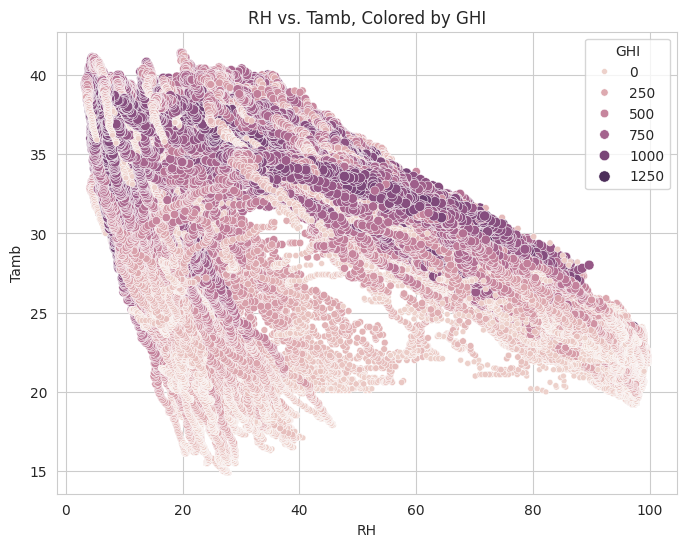

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="RH", y="Tamb", hue="GHI", size="GHI", data=df)
plt.title("RH vs. Tamb, Colored by GHI")
plt.show()

#### 10. Bubble Chart
* Plot GHI vs. Tamb, with bubble size = RH.

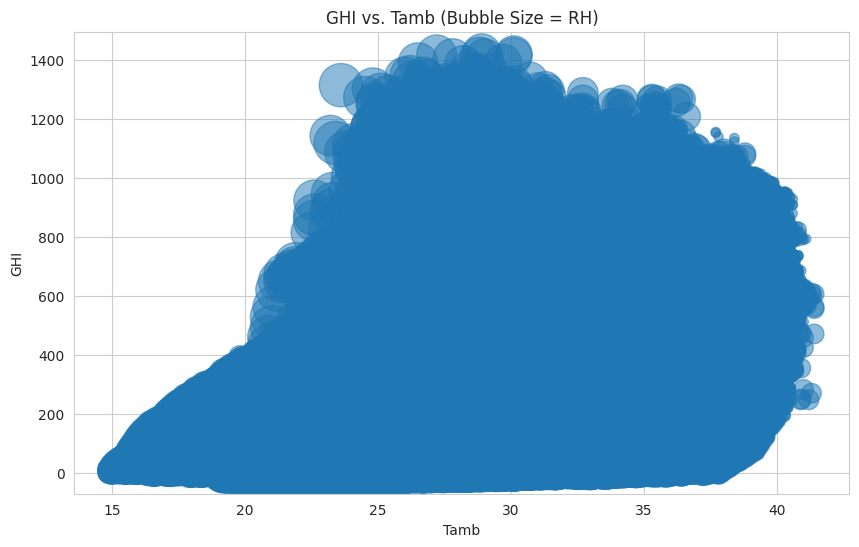

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Tamb"], df["GHI"], s=df["RH"]*10, alpha=0.5)
plt.title("GHI vs. Tamb (Bubble Size = RH)")
plt.xlabel("Tamb")
plt.ylabel("GHI")
plt.show()

### 11. Key Insights
#### Missing Values:

* The Comments column is 100% missing (525,600 nulls), indicating it contains no data and should be dropped to reduce memory usage and simplify analysis.
#### Outliers:

* Outlier Mean: On average, ~1.8% of rows (mean of 1,649 outliers across GHI (305), DNI (1062), DHI (3415), ModA (137), ModB (206), WS (3510), WSgust (3915)) show outliers, with WSgust (0.74%) and DHI (0.65%) most variable. 
 #### Time Series

  * Diurnal & Seasonal Trends: GHI, DNI, DHI peak midday, highest in Feb–Apr (~500 W/m²), lowest in Jul–Aug (~400 W/m²); Tamb stable at 25–35°C, peaking in Mar (~35°C).

#### Cleaning Impact:

 * Cleaning Impact: Cleaning reduces ModA (500 to 320 W/m²) and ModB (480 to 300 W/m²) by ~36%, indicating dust significantly inflates pre-cleaning readings.
#### Correlation
 * Correlation: GHI, DNI, ModA, ModB, TModA, TModB highly correlated (r = 0.81–0.99); RH negatively impacts GHI (r = -0.32) and Tamb (r = -0.57).
   
#### Wind Analysis

  * Wind Rose: Prevailing winds from NE–E (4.5–12 m/s), with speeds mostly 3–10 m/s, guiding panel orientation.
#### Distribution Analysis

   * Histograms: GHI bimodal (~0, ~800 W/m², night/day); WS right-skewed, peaks at ~4 m/s, fits Weibull distribution.

## References
#### GitHub Actions Documentation
  *  URL: https://docs.github.com/en/actions
#### Python Virtual Environments (venv) Documentation
  *  URL: https://docs.python.org/3/library/venv.html
#### Pandas Documentation
  * URL: https://pandas.pydata.org/docs/
#### Seaborn Documentation

   * URL: https://seaborn.pydata.org/
####   Matplotlib Documentation

   * URL: https://matplotlib.org/stable/contents.html
#### SciPy Stats Documentation

   * URL: https://docs.scipy.org/doc/scipy/reference/stats.html
